This dataset and notebook correspond to the [Food Recognition Challenge](https://www.aicrowd.com/challenges/food-recognition-challenge) being held on [AICrowd](https://www.aicrowd.com/).

In this Notebook, we will first do an analysis of the Food Recognition Dataset and then use maskrcnn for training on the dataset.

## The Challenge


*   Given Images of Food, we are asked to provide Instance Segmentation over the images for the food items.
*   The Training Data is provided in the COCO format, making it simpler to load with pre-available COCO data processors in popular libraries.
*   The test set provided in the public dataset is similar to Validation set, but with no annotations.
*   The test set after submission is much larger and contains private images upon which every submission is evaluated.
*   Pariticipants have to submit their trained model along with trained weights. Immediately after the submission the AICrowd Grader picks up the submitted model and produces inference on the private test set using Cloud GPUs.
*   This requires Users to structure their repositories and follow a provided paradigm for submission.
*   The AICrowd AutoGrader picks up the Dockerfile provided with the repository, builds it and then mounts the tests folder in the container. Once inference is made, the final results are checked with the ground truth.

***For more submission related information, please check [the AIcrowd Challenge page](https://www.aicrowd.com/challenges/food-recognition-challenge) and [the starter kit](https://github.com/AIcrowd/food-recognition-challenge-starter-kit/).***

## The Notebook
> *  Installation of MMDetection
> *  Training a simple model with MMDetection
> *  Local Evaluation using MMDetection

**Bonus : Creating a submission through Google Colab**

# GPU Check

Do a quick check if you have been allocated a GPU. 

If this command fails for you, please go to `Runtime` -> `Change Runtime Type` -> `Hardware Accelerator` -> `GPU`

In [1]:
!nvidia-smi

Mon Aug 10 12:48:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset Download

**Note:** By downloading this data you are argeeing to the competition rules specified [here](https://www.aicrowd.com/challenges/food-recognition-challenge/challenge_rules/150)

In [2]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/train.tar.gz
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/val.tar.gz

In [3]:
!mkdir data
!mkdir data/val
!mkdir data/train
!tar -xf train.tar.gz -C data/train
!tar -xf val.tar.gz -C data/val

# Installation

In [4]:
!wget https://download.pytorch.org/whl/cu101/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!wget https://download.pytorch.org/whl/cu101/torchvision-0.5.0-cp36-cp36m-linux_x86_64.whl

--2020-08-10 12:50:59--  https://download.pytorch.org/whl/cu101/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
Resolving download.pytorch.org (download.pytorch.org)... 13.227.45.38, 13.227.45.53, 13.227.45.86, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.45.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 753377187 (718M) [binary/octet-stream]
Saving to: ‘torch-1.4.0-cp36-cp36m-linux_x86_64.whl’

torch-1.4.0-cp36-cp 100%[===================>] 718.48M  89.6MB/s    in 8.0s    

2020-08-10 12:51:07 (89.9 MB/s) - ‘torch-1.4.0-cp36-cp36m-linux_x86_64.whl’ saved [753377187/753377187]

--2020-08-10 12:51:08--  https://download.pytorch.org/whl/cu101/torchvision-0.5.0-cp36-cp36m-linux_x86_64.whl
Resolving download.pytorch.org (download.pytorch.org)... 13.227.45.38, 13.227.45.53, 13.227.45.86, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.45.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4037332 (3.

In [5]:
!pip install torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision-0.5.0-cp36-cp36m-linux_x86_64.whl

Processing ./torch-1.4.0-cp36-cp36m-linux_x86_64.whl
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
Processing ./torchvision-0.5.0-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [6]:
!pip install numpy==1.17.0

     |████████████████████████████████| 20.4MB 1.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


#### **Note:** Before continuing restart runtime

To restart runtime : `Runtime` > `Restart Runtime`

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
!git clone --branch v1.0rc1 https://github.com/open-mmlab/mmdetection.git mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 12599, done.
remote: Total 12599 (delta 0), reused 0 (delta 0), pack-reused 12599
Receiving objects: 100% (12599/12599), 11.55 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (8656/8656), done.
Note: checking out '4357697acaaf7b3eb17a9e78f2e0b8996bcf4e73'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [2]:
cd mmdetection

/content/mmdetection


In [3]:
!pip install -q mmcv terminaltables
!pip install -v -e .[optional]
!pip install -r "requirements.txt"

Streaming output truncated to the last 5000 lines.
       AT_CHECK(x.is_contiguous(), #x, " must be contiguous ")
       ^~~~~~~~
    mmdet/ops/roi_pool/src/roi_pool_cuda.cpp:24:3: note: in expansion of macro ‘CHECK_CONTIGUOUS’
       CHECK_CONTIGUOUS(x)
       ^~~~~~~~~~~~~~~~
    mmdet/ops/roi_pool/src/roi_pool_cuda.cpp:31:3: note: in expansion of macro ‘CHECK_INPUT’
       CHECK_INPUT(rois);
       ^
    In file included from /usr/local/lib/python3.6/dist-packages/torch/include/c10/core/Device.h:5:0,
                     from /usr/local/lib/python3.6/dist-packages/torch/include/c10/core/Allocator.h:6,
                     from /usr/local/lib/python3.6/dist-packages/torch/include/ATen/ATen.h:3,
                     from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/types.h:3,
                     from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader_options.h:4,
                     from /usr/local/l

In [4]:
cd ..

/content


In [5]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

Uninstalling pycocotools-2.0.1:
  Successfully uninstalled pycocotools-2.0.1


## Imports


In [2]:
#Directories present
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('data/'):
        print(dirname)
import os
import sys
sys.path.append("mmdetection")
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

data/
data/train
data/train/images
data/val
data/val/test_images
data/val/test_images/images
data/val/images


In [3]:
np.__version__

'1.17.0'

In [4]:
pwd

'/content'

## Config

In [5]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'htc_without_semantic_r50_fpn_1x': {
        'config_file': 'configs/htc/htc_without_semantic_r50_fpn_1x.py'
    }
}

In [6]:
# Pick the model you want to use
selected_model = 'htc_without_semantic_r50_fpn_1x' # chose any config you want from the MODELS_CONFIG

# Total training epochs.
total_epochs = 2         #To train more increase no of epochs here

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

In [7]:
import os
config_fname = os.path.join('mmdetection', config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'mmdetection/configs/htc/htc_without_semantic_r50_fpn_1x.py'

In [8]:
# Explore classes to predict, we will use this while editing the config
import json
annotation_path = os.path.join("data", "train/annotations.json")
json_file = open(annotation_path)
coco = json.load(json_file)
print(coco["categories"])
classes_names = [category["name"] for category in coco["categories"]]
print(classes_names)

[{'id': 2578, 'name': 'water', 'name_readable': 'Water', 'supercategory': 'food'}, {'id': 2939, 'name': 'pizza-margherita-baked', 'name_readable': 'Pizza, Margherita, baked', 'supercategory': 'food'}, {'id': 1085, 'name': 'broccoli', 'name_readable': 'Broccoli', 'supercategory': 'food'}, {'id': 1040, 'name': 'salad-leaf-salad-green', 'name_readable': 'Salad, leaf / salad, green', 'supercategory': 'food'}, {'id': 1070, 'name': 'zucchini', 'name_readable': 'Zucchini', 'supercategory': 'food'}, {'id': 2022, 'name': 'egg', 'name_readable': 'Egg', 'supercategory': 'food'}, {'id': 2053, 'name': 'butter', 'name_readable': 'Butter', 'supercategory': 'food'}, {'id': 1566, 'name': 'bread-white', 'name_readable': 'Bread, white', 'supercategory': 'food'}, {'id': 1151, 'name': 'apple', 'name_readable': 'Apple', 'supercategory': 'food'}, {'id': 2131, 'name': 'dark-chocolate', 'name_readable': 'Dark chocolate', 'supercategory': 'food'}, {'id': 2521, 'name': 'white-coffee-with-caffeine', 'name_readabl

In [9]:
##Here is the raw config file, we will make changes to this to suit our purpose
!cat {config_fname}

# model settings
model = dict(
    type='HybridTaskCascade',
    num_stages=3,
    pretrained='torchvision://resnet50',
    interleaved=True,
    mask_info_flow=True,
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    bbox_roi_extractor=dict(
        type='SingleRoIExtractor',
        roi_laye

### Edit config

We will edit the config to be suited to the food dataset, there are a lot of parameters other than the ones we have changed below that one can edit in the existing config file that might lead to a better score. We leave that upto you, do feel free to explore documentation for [mmdetection](https://github.com/open-mmlab/mmdetection/tree/master/docs).

**Note:** Instead of using regular expressions to edit the existing file, feel free to download the config file and edit it using the text editor of your choice and then reupload the same and have the variable config_fname point to the same

In [10]:
import re
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = re.findall(r"work_dir = \'(.*?)\'", s)[0]
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} '.format(total_epochs), s)
    s = re.sub("data_root = 'data/coco/'",
                "data_root = 'data/'", s)
    s = re.sub("annotations/instances_train2017.json",
                "train/annotations.json", s)
    s = re.sub("annotations/instances_val2017.json",
                "val/annotations.json", s)
    s = re.sub("annotations/instances_val2017.json",
                "val/annotations.json", s)
    s = re.sub("train2017", "train/images", s)
    s = re.sub("val2017", "val/images", s)
    s = re.sub("workers_per_gpu=2","workers_per_gpu=0",s)
    s = re.sub("imgs_per_gpu=2","imgs_per_gpu=4",s) 
    s = re.sub("lr=0.02","lr=0.0025",s)  #need to change lr to 0.0025 since we are working with only 1 gpu

with open(fname, 'w') as f:
    f.write(s)
#lets check if the changes have been updated
!cat {config_fname}

# model settings
model = dict(
    type='HybridTaskCascade',
    num_stages=3,
    pretrained='torchvision://resnet50',
    interleaved=True,
    mask_info_flow=True,
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    bbox_roi_extractor=dict(
        type='SingleRoIExtractor',
        roi_laye

In [15]:
# Add a try except block in the function prepare_train_img
# to make sure training doesn't stop while reading erronous images
# Navigate to the /content/mmdetection/mmdet/datasets/custom.py file(use file explorer on the sidebar) 
# and replace the existing definition of prepare_train_img with:
'''
    def prepare_train_img(self, idx):
        img_info = self.img_infos[idx]
        ann_info = self.get_ann_info(idx)
        results = dict(img_info=img_info, ann_info=ann_info)
        try:    
          if self.proposals is not None:
              results['proposals'] = self.proposals[idx]
          self.pre_pipeline(results)
          return self.pipeline(results)
        except:
          print("Error loading,",img_info)
'''
#then save the file by pressing ctrl+s

'\n    def prepare_train_img(self, idx):\n        img_info = self.img_infos[idx]\n        ann_info = self.get_ann_info(idx)\n        results = dict(img_info=img_info, ann_info=ann_info)\n        try:    \n          if self.proposals is not None:\n              results[\'proposals\'] = self.proposals[idx]\n          self.pre_pipeline(results)\n          return self.pipeline(results)\n        except:\n          print("Error loading,",img_info)\n'

## Train!

In [28]:
!pip install mmcv==0.4.3


     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for mmcv: filename=mmcv-0.4.3-cp36-cp36m-linux_x86_64.whl size=170843 sha256=93ca1c6707910bf930d00d8ba7760480bed87869d4bca4392517f708f1a3730c
  Stored in directory: /root/.cache/pip/wheels/1e/c3/ee/7eddece4815cfe949be3d489912d22465e244260b587bb05e1
Successfully built mmcv
  Found existing installation: mmcv 1.0.5
    Uninstalling mmcv-1.0.5:
      Successfully uninstalled mmcv-1.0.5


In [13]:
#Lets train the model
!python mmdetection/tools/train.py {config_fname}

2020-08-10 13:19:31,866 - INFO - Distributed training: False
2020-08-10 13:19:31,866 - INFO - MMDetection Version: 1.0rc1+4357697
2020-08-10 13:19:31,866 - INFO - Config: /content/mmdetection/configs/htc/htc_without_semantic_r50_fpn_1x.py
# model settings
model = dict(
    type='HybridTaskCascade',
    num_stages=3,
    pretrained='torchvision://resnet50',
    interleaved=True,
    mask_info_flow=True,
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls

In [14]:
#lets get the latest checkpoint file 
checkpoint_file = os.path.join(work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file = os.path.abspath(checkpoint_file)
checkpoint_file

'/content/work_dirs/htc_without_semantic_r50_fpn_1x/latest.pth'

## Testing

In [15]:
#Lets visualize some results
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab

def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result, init_detector

In [16]:
score_thr = 0.3 #decrease the threshold if you feel like you are missing some predictions

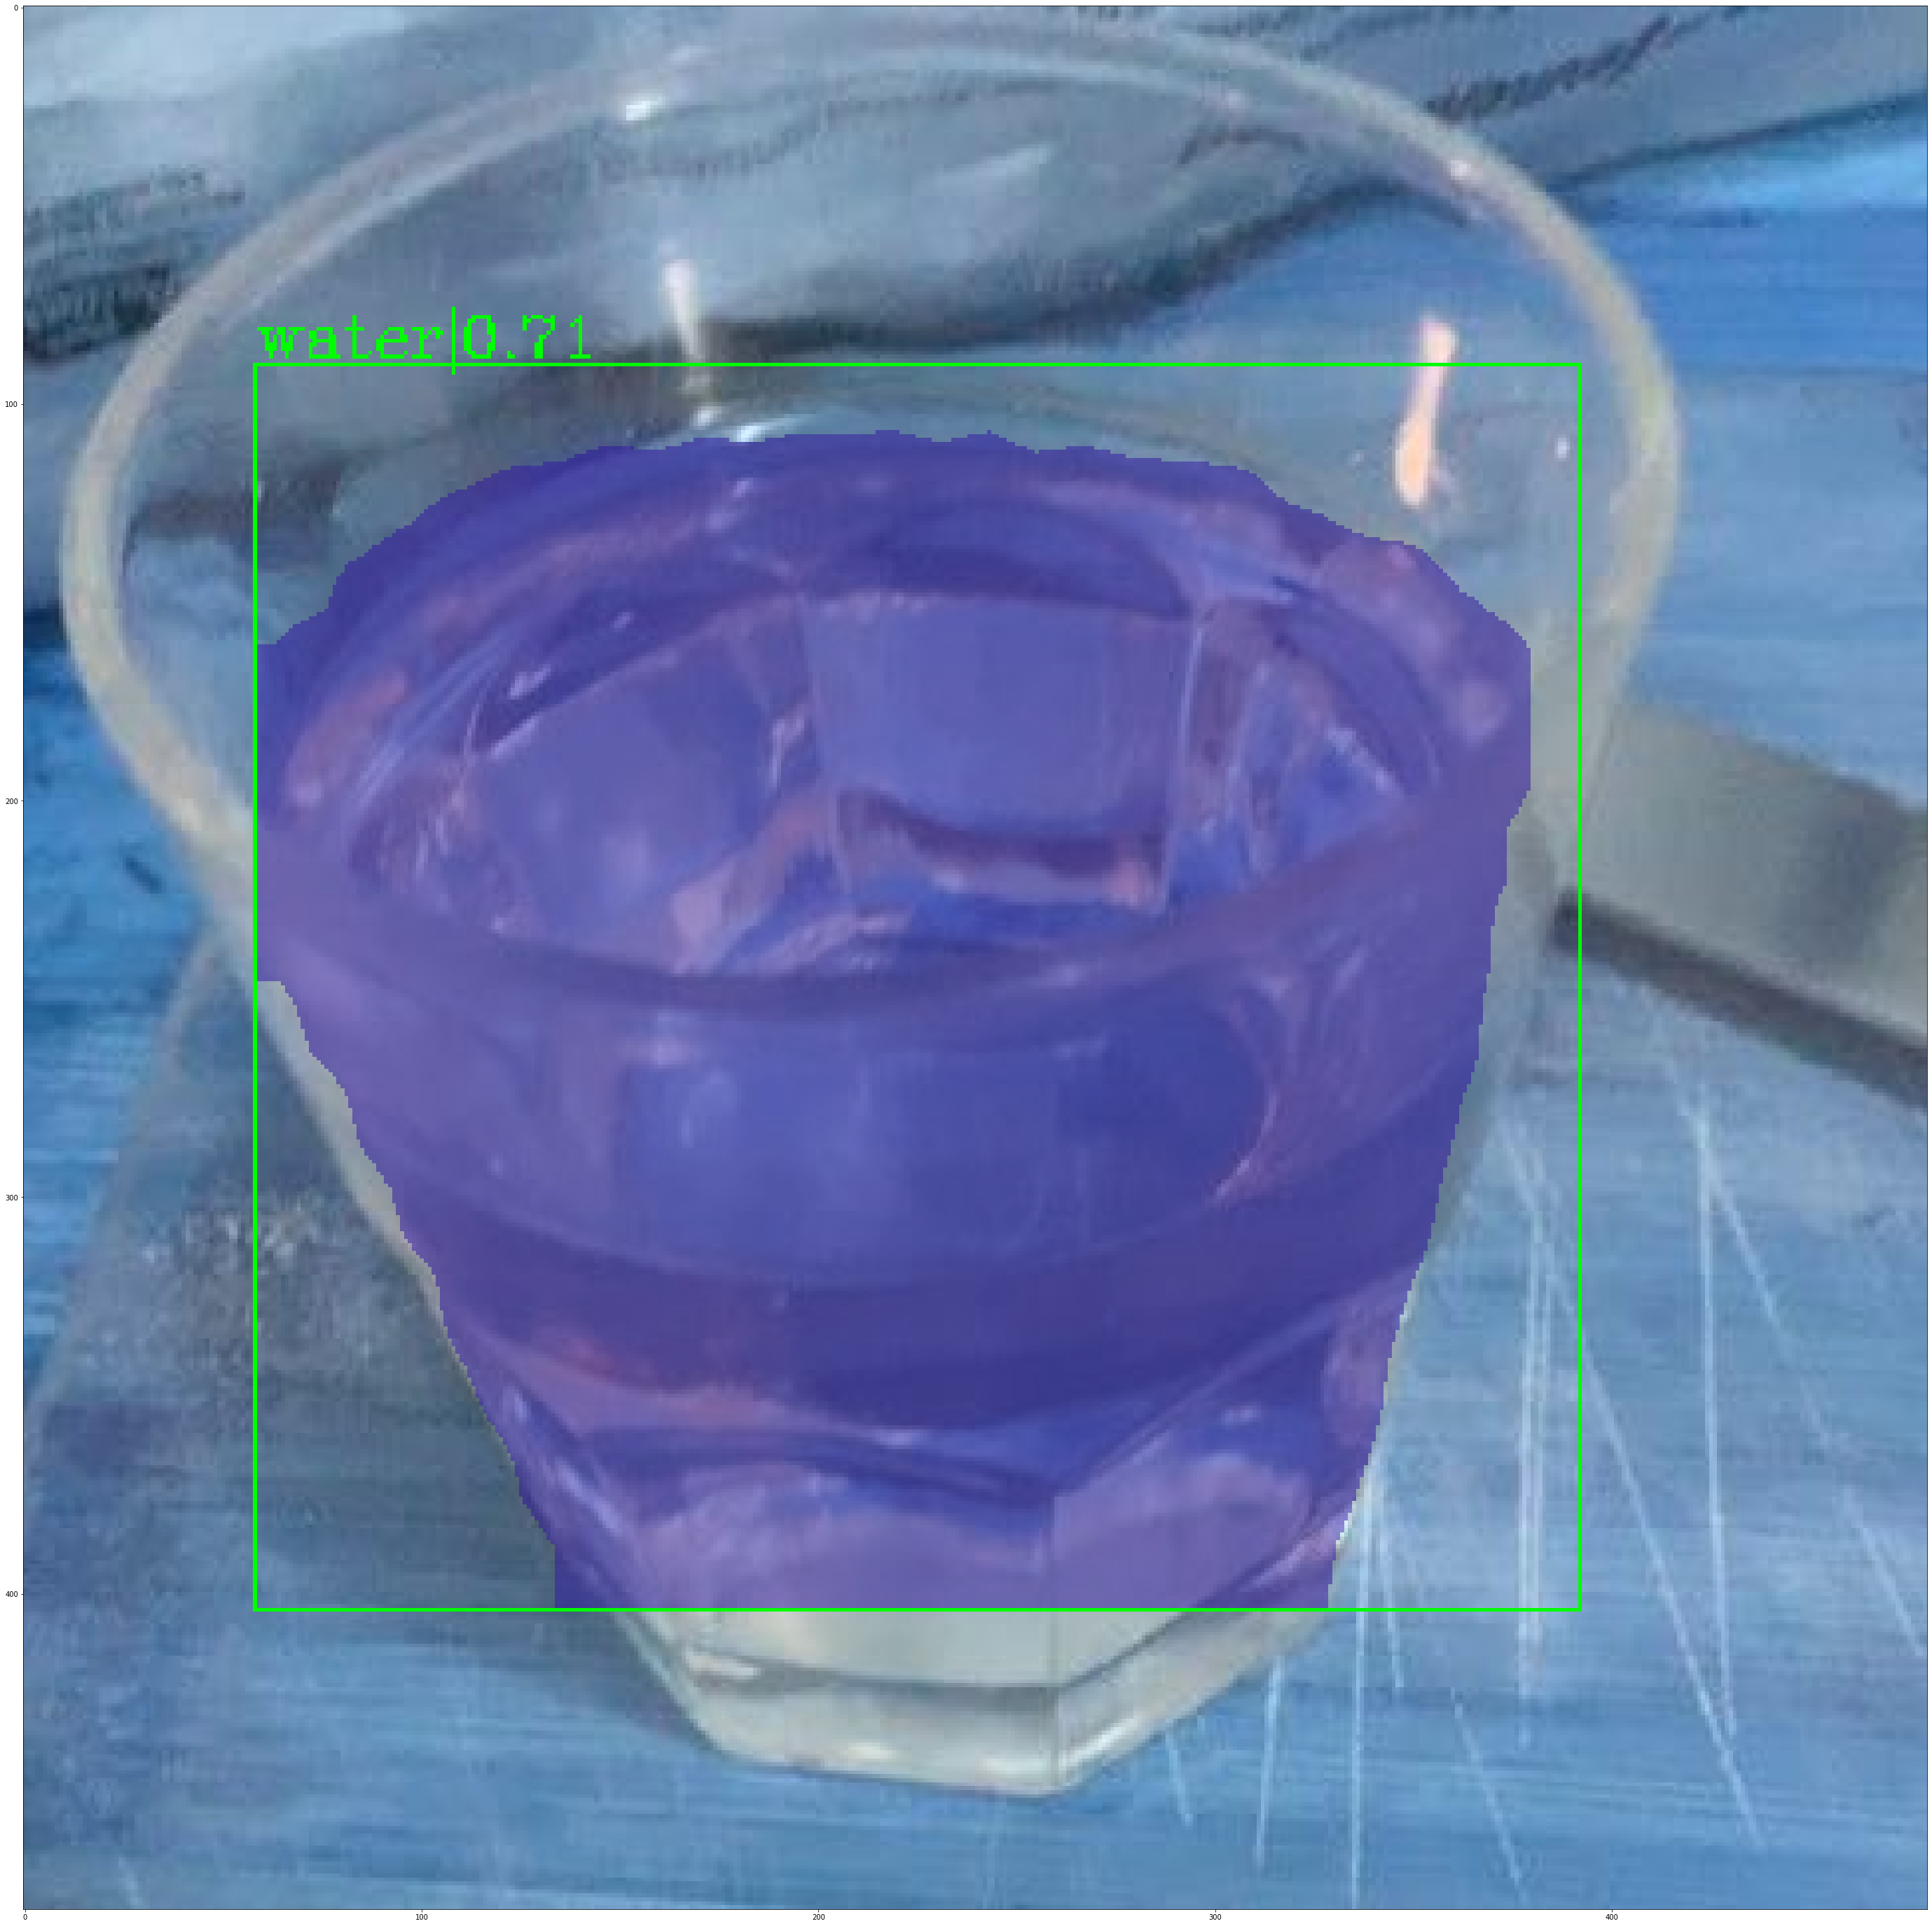

In [17]:

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = '/content/data/val/images/007908.jpg'   #you can change this to any image you want!

result = inference_detector(model, img)
show_result(img, result, classes_names,
            score_thr=score_thr, out_file="result.jpg")

In [18]:
#Lets check out the results on the entire val set
!python mmdetection/tools/test.py {config_fname} {checkpoint_file} --eval segm --json_out results.json

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[>>] 418/418, 1.4 task/s, elapsed: 301s, ETA:     0s

In [19]:
ls

data/              results.segm.json                              train.tar.gz
mmdetection/       sample_data/                                   val.tar.gz
result.jpg         torch-1.4.0-cp36-cp36m-linux_x86_64.whl        work_dirs/
results.bbox.json  torchvision-0.5.0-cp36-cp36m-linux_x86_64.whl


As we see the predictions have been saved to results.bbox.json (for bbox results) and results.segm.json (for masks results). A similiar json to results.segm.json is created for the test set images and is what gets you your score on the leaderboard. The following script lets you evaluate your results locally for the val set.

## Evaluation

In [20]:
import random
import json
import numpy as np
import argparse
import base64
import glob
import os
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
IMAGES_DIR = "data/val/food_val/images"
GROUND_TRUTH_ANNOTATION_PATH = "data/val/annotations.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
submission_file = json.loads(open("results.segm.json").read())
results = ground_truth_annotations.loadRes(submission_file)
cocoEval = COCOeval(ground_truth_annotations, results, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
cocoEval = COCOeval(ground_truth_annotations, results, 'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()



loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=6.10s).
Accumulating evaluation results...
DONE (t=1.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets